In [2]:
!pip3 install pandas_summary isoweek sklearn_pandas -i https://pypi.tuna.tsinghua.edu.cn/simple
! pip3 install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.5/dist-packages
Requirement already up-to-date: scipy>=0.14 in /usr/local/lib/python3.5/dist-packages (from keras)
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python3.5/dist-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /usr/local/lib/python3.5/dist-packages (from keras)
Requirement already up-to-date: pyyaml in /usr/local/lib/python3.5/dist-packages (from keras)


In [3]:
%matplotlib inline
from imp import reload
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
from pandas_summary import DataFrameSummary
import bld_etl; reload(bld_etl)
from bld_etl import read_raw, loadtypes, add_datepart, fillna, type_map, get_data

In [4]:
%matplotlib inline
np.set_printoptions(threshold=50, edgeitems=20)

In [8]:
merged_df = pd.read_json('/data/ai_opinfo_2017-01_to_2017-10.json', lines=True)

In [13]:
# filtered the data without RBC
merged_df = merged_df[~merged_df.TRANS_RBC.isnull()]

In [15]:
y_df, x_df = read_raw(merged_df)
contin_vars, cat_vars, dt_vars, text_vars, const_vars = loadtypes(x_df)
# drop the cols with contant value, cause this contribute nothing to predicted results
x_df.drop(const_vars, axis=1, inplace=True, errors="ignore")
add_datepart(x_df, dt_vars)
fillna(x_df, contin_vars, cat_vars)
x_df.to_pickle('/data/result/cleaned_data.pkl')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [16]:
joined = pd.read_pickle('/data/result/cleaned_data.pkl')

In [17]:
contin_vars.remove('TRANS_RBC')

In [19]:
cat_map_fit, contin_map_fit, contin_cols = type_map(joined, cat_vars, contin_vars, use_cache=False, cache_dir='/data/result')

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
x_train, y_train, x_valid, y_valid, cat_map_train, cat_map_valid, contin_map_train, contin_map_valid = get_data(joined, cat_map_fit, contin_map_fit)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(4500, 54) (4500,) (500, 54) (500,)


/notebooks/bld_etl.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  joined_train.drop('TRANS_RBC', axis=1, inplace=True)
/notebooks/bld_etl.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  joined_valid.drop('TRANS_RBC', axis=1, inplace=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
# from tpot import TPOTRegressor

# tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2)
# tpot.fit(x_train, y_train)
# print(tpot.score(x_valid, y_valid))
# predicted = tpot.predict(x_valid)
# diff = np.abs(predicted - y_valid.values)
# len(diff[diff <= 1]) / len(diff)

Missing, 
- Durations between opt
- Doctor's trend between trans, rolling avg

## keras

In [23]:
def rmspe(y_pred, targ = y_valid):
    pct_var = (targ - y_pred)/targ
    return math.sqrt(np.square(pct_var).mean())
# def log_max_inv(preds, mx = max_log_y):
#     return np.exp(preds * mx)
def normalize_inv(preds):
    return preds * ystd + ymean

In [24]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [25]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [26]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [27]:
cat_map_info(cat_map_fit.features[2])

('OP_DOCT_NAME', 297)

In [28]:
from keras.layers import Input, Dense, Flatten, Dropout, Embedding, Concatenate
from keras import initializers, Model

def my_init(scale):
    return initializers.RandomNormal() #lambda shape, name=None: initializers.uniform(shape, scale=scale, name=name)
def emb_init(shape, name=None): 
    return initializers.RandomNormal() # initializers.uniform(shape, scale=2/(shape[1]+1), name=name)
def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp)) # , init=emb_init
    return inp,u
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d')(inp) # , init=my_init(1.)

contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)
embs = [get_emb(feat) for feat in cat_map_fit.features]
# conts = [get_contin(feat) for feat in contin_map_fit.features]
# contin_d = [d for inp,d in conts]
x = Concatenate()([emb for inp,emb in embs] + [contin_out])
#x = merge([emb for inp,emb in embs] + contin_d, mode='concat')

x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', kernel_initializer='uniform')(x)
x = Dense(500, activation='relu', kernel_initializer='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='linear')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
#model = Model([inp for inp,emb in embs] + [inp for inp,d in conts], x)
model.compile('adam', 'mean_squared_error')

In [39]:
%%time 
hist = model.fit(map_train, y_train, batch_size=128, epochs=30,
                 verbose=0, validation_data=(map_valid, y_valid))

CPU times: user 12 s, sys: 1.72 s, total: 13.7 s
Wall time: 6.99 s


In [40]:
import matplotlib.pyplot as plt
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

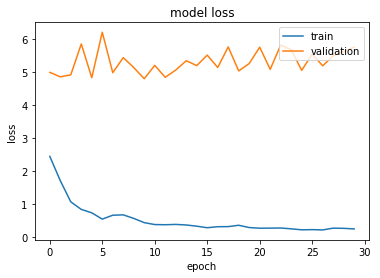

In [41]:

plot_train(hist)

In [43]:
map_train[8].shape

(4500, 46)

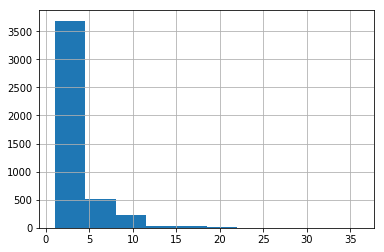

In [45]:
y_train.hist()

In [31]:
hist